# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x


# taken from CVT-CCT paper
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size: int=7, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding: int=1,
                 conv_layers: int=2, input_channels: int=3, 
                 output_channels: int=64, in_planes: int=64):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, in_planes,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.max_pool = nn.MaxPool2d(kernel_size=pooling_kernel_size,
                                     stride=pooling_stride,
                                     padding=pooling_padding)
        
        self.conv2 = nn.Conv2d(in_planes, output_channels,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)


class CvT(nn.Module):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__()
        
        self.tokenizer = Tokenizer(kernel_size=kernel_size, stride=stride, 
                                   padding=padding, pooling_kernel_size=pooling_kernel_size, 
                                   pooling_stride=pooling_stride, pooling_padding=pooling_padding, 
                                   conv_layers=conv_layers, input_channels=in_channels, 
                                   output_channels=embedding_dim, in_planes=in_planes)
        
        self.attention_pool = nn.Linear(embedding_dim, 1)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        
        self.norm = nn.LayerNorm(embedding_dim)
        
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.tokenizer(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        x = self.head(x)
        
        return x
    
class CvT_3(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=3, embedding_dim: int=192, mlp_size: int=384,
                 num_heads: int=3, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_7(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_14(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=14, embedding_dim: int=384, mlp_size: int=1152,
                 num_heads: int=6, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = CvT_14()
model = model.to(config['DEVICE'])
model_name = "cvt_14"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CvT_14 (CvT_14)                                         [32, 3, 224, 224]    [32, 10]             --                   True
├─Tokenizer (tokenizer)                                 [32, 3, 224, 224]    [32, 196, 384]       --                   True
│    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─MaxPool2d (max_pool)                             [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Conv2d (conv2)                                   [32, 64, 56, 56]     [32, 384, 28, 28]    1,204,224            True
│    └─MaxPool2d (max_pool)                             [32, 384, 28, 28]    [32, 384, 14, 14]    --                   --
│    └─Flatten (flatten)                                [32, 384, 14, 14]    [32, 384, 196]       --                   --
├─Dropout

# Training

Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 1 | Train Loss: 2.3226206073557356 | Accuracy: 0.11204637939684486 | Precision: 0.10678978119699473 | Recall: 0.11204637939684486 | F1: 0.10517825095262447


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.2888727423170923 | Accuracy: 0.12129319955406911 | Precision: 0.04699013225420002 | Recall: 0.12129319955406911 | F1: 0.05031698717312181
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 2 | Train Loss: 1.9941224869459973 | Accuracy: 0.231283795083338 | Precision: 0.21750208440849297 | Recall: 0.231283795083338 | F1: 0.21448661188098145


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.36it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 1.6946054663456662 | Accuracy: 0.3346711259754738 | Precision: 0.34215778550512727 | Recall: 0.3346711259754738 | F1: 0.2592706820961439
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 3 | Train Loss: 1.4056653490694393 | Accuracy: 0.46557779140420313 | Precision: 0.45258838528280654 | Recall: 0.46557779140420313 | F1: 0.4536811092603613


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.56it/s]


	Validation Loss: 1.2241255775303908 | Accuracy: 0.5199554069119287 | Precision: 0.5702885083744638 | Recall: 0.5199554069119287 | F1: 0.501543795801853
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 4 | Train Loss: 0.963008089421907 | Accuracy: 0.6566698255198171 | Precision: 0.6523080125695216 | Recall: 0.6566698255198171 | F1: 0.6521112735598058


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.67it/s]


	Validation Loss: 0.6822372653954466 | Accuracy: 0.769453734671126 | Precision: 0.7808672699243628 | Recall: 0.769453734671126 | F1: 0.7659406107948564
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 5 | Train Loss: 0.6145409090026842 | Accuracy: 0.7896203801772674 | Precision: 0.786759299725627 | Recall: 0.7896203801772674 | F1: 0.7873915568218642


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.48it/s]


	Validation Loss: 0.38855754951356164 | Accuracy: 0.8684503901895206 | Precision: 0.8713218010889885 | Recall: 0.8684503901895206 | F1: 0.8651346420910426
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 6 | Train Loss: 0.4045045747822714 | Accuracy: 0.8622554211494509 | Precision: 0.8610493488724975 | Recall: 0.8622554211494509 | F1: 0.8613136186679436


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.60it/s]


	Validation Loss: 0.24732391043028362 | Accuracy: 0.9139353400222966 | Precision: 0.914628848689133 | Recall: 0.9139353400222966 | F1: 0.9131102051163443
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 7 | Train Loss: 0.3054454962713014 | Accuracy: 0.8970399687830983 | Precision: 0.8966747702543701 | Recall: 0.8970399687830983 | F1: 0.8966948209820812


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.69it/s]


	Validation Loss: 0.23368041406215076 | Accuracy: 0.9228539576365663 | Precision: 0.92709809873247 | Recall: 0.9228539576365663 | F1: 0.9237571538345216
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 8 | Train Loss: 0.26077151083755323 | Accuracy: 0.9135403311221362 | Precision: 0.9132616207124088 | Recall: 0.9135403311221362 | F1: 0.9132813685482385


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.55it/s]


	Validation Loss: 0.2203591059840901 | Accuracy: 0.9273132664437013 | Precision: 0.931371902649455 | Recall: 0.9273132664437013 | F1: 0.9264429816026603
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 9 | Train Loss: 0.20186274990545472 | Accuracy: 0.9334968504375941 | Precision: 0.9334179107577142 | Recall: 0.9334968504375941 | F1: 0.9333911535050443


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.64it/s]


	Validation Loss: 0.13968705055369457 | Accuracy: 0.9596432552954292 | Precision: 0.9605872786389898 | Recall: 0.9596432552954292 | F1: 0.9594427298368047
Saving best model at epoch 9...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 10 | Train Loss: 0.17830916898477545 | Accuracy: 0.9403534199230726 | Precision: 0.9402675088861616 | Recall: 0.9403534199230726 | F1: 0.9402638990589888


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.76it/s]


	Validation Loss: 0.11734748033570572 | Accuracy: 0.9623188405797102 | Precision: 0.9625126049771439 | Recall: 0.9623188405797102 | F1: 0.9621659641563083
Saving best model at epoch 10...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 11 | Train Loss: 0.14723422480382528 | Accuracy: 0.9528401806120742 | Precision: 0.9527844709151319 | Recall: 0.9528401806120742 | F1: 0.9527846130447085


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.58it/s]


	Validation Loss: 0.0976228692477018 | Accuracy: 0.9703455964325529 | Precision: 0.9706778682885634 | Recall: 0.9703455964325529 | F1: 0.9702752211967185
Saving best model at epoch 11...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 12 | Train Loss: 0.12647623941799446 | Accuracy: 0.9587490941524054 | Precision: 0.9587110685632955 | Recall: 0.9587490941524054 | F1: 0.9587127806524922


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.59it/s]


	Validation Loss: 0.0793505894990874 | Accuracy: 0.9765886287625418 | Precision: 0.9767497865324536 | Recall: 0.9765886287625418 | F1: 0.9765938882170104
Saving best model at epoch 12...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 13 | Train Loss: 0.13101728231351145 | Accuracy: 0.9576342048051731 | Precision: 0.9576032522865946 | Recall: 0.9576342048051731 | F1: 0.9575924877747285


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.80it/s]


	Validation Loss: 0.10014322158736243 | Accuracy: 0.9698996655518395 | Precision: 0.9702068337292098 | Recall: 0.9698996655518395 | F1: 0.969762259298641


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 14 | Train Loss: 0.11270000571484455 | Accuracy: 0.9629299292045265 | Precision: 0.9629061471840304 | Recall: 0.9629299292045265 | F1: 0.9628947502370021


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.57it/s]


	Validation Loss: 0.12997810888878056 | Accuracy: 0.9614269788182832 | Precision: 0.9636427437660205 | Recall: 0.9614269788182832 | F1: 0.9616246473525413


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 15 | Train Loss: 0.10249803930660213 | Accuracy: 0.9672779976587323 | Precision: 0.9672685149120794 | Recall: 0.9672779976587323 | F1: 0.9672605649581368


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.54it/s]


	Validation Loss: 0.07964758870100051 | Accuracy: 0.9770345596432553 | Precision: 0.97747600440843 | Recall: 0.9770345596432553 | F1: 0.9769944795833244


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 16 | Train Loss: 0.09367769320737372 | Accuracy: 0.968783098277496 | Precision: 0.968735171709316 | Recall: 0.968783098277496 | F1: 0.9687420132718686


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.17it/s]


	Validation Loss: 0.0842517804039616 | Accuracy: 0.9727982162764771 | Precision: 0.9732885938286547 | Recall: 0.9727982162764771 | F1: 0.9727699252713703


Training: 100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Epoch 17 | Train Loss: 0.08711563340583783 | Accuracy: 0.9715703216455767 | Precision: 0.9715712114261891 | Recall: 0.9715703216455767 | F1: 0.9715610036157964


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.30it/s]


	Validation Loss: 0.09724648484409275 | Accuracy: 0.9719063545150501 | Precision: 0.9726945591335471 | Recall: 0.9719063545150501 | F1: 0.971964651219868


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 18 | Train Loss: 0.0755596291795837 | Accuracy: 0.9746362673504655 | Precision: 0.9746391248177084 | Recall: 0.9746362673504655 | F1: 0.9746317223139886


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.59it/s]


	Validation Loss: 0.0843802211858647 | Accuracy: 0.9736900780379041 | Precision: 0.9741791269490334 | Recall: 0.9736900780379041 | F1: 0.9734889262510529


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 19 | Train Loss: 0.07808476576276681 | Accuracy: 0.9737443558726796 | Precision: 0.9737474227796977 | Recall: 0.9737443558726796 | F1: 0.9737405322597089


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.41it/s]


	Validation Loss: 0.07543288642199526 | Accuracy: 0.9783723522853958 | Precision: 0.9789840587009225 | Recall: 0.9783723522853958 | F1: 0.9784443170573941
Saving best model at epoch 19...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 20 | Train Loss: 0.0688858238368683 | Accuracy: 0.9766988126428452 | Precision: 0.9767054629864099 | Recall: 0.9766988126428452 | F1: 0.9766962218830065


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


	Validation Loss: 0.06419007930065125 | Accuracy: 0.979933110367893 | Precision: 0.9801972564592066 | Recall: 0.979933110367893 | F1: 0.9799389058890197
Saving best model at epoch 20...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 21 | Train Loss: 0.07324195764395425 | Accuracy: 0.976141367969229 | Precision: 0.9761280693887385 | Recall: 0.976141367969229 | F1: 0.9761288756045042


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.63it/s]


	Validation Loss: 0.0628171381179873 | Accuracy: 0.9821627647714605 | Precision: 0.9822946451720476 | Recall: 0.9821627647714605 | F1: 0.9821633401344891
Saving best model at epoch 21...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 22 | Train Loss: 0.06510020542253485 | Accuracy: 0.9788171024025866 | Precision: 0.9788109118031577 | Recall: 0.9788171024025866 | F1: 0.9788127897040095


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.55it/s]


	Validation Loss: 0.09452913457881922 | Accuracy: 0.9710144927536232 | Precision: 0.9729721992221261 | Recall: 0.9710144927536232 | F1: 0.9708452586310338


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 23 | Train Loss: 0.05209865115062595 | Accuracy: 0.9837226155304086 | Precision: 0.9837204339675824 | Recall: 0.9837226155304086 | F1: 0.9837202792661716


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.61it/s]


	Validation Loss: 0.06742330718601883 | Accuracy: 0.9788182831661093 | Precision: 0.97926545938699 | Recall: 0.9788182831661093 | F1: 0.9787967430385374


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 24 | Train Loss: 0.06715196842705545 | Accuracy: 0.9785941245331401 | Precision: 0.978609427061391 | Recall: 0.9785941245331401 | F1: 0.9786004662583329


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.59it/s]


	Validation Loss: 0.05204629256967193 | Accuracy: 0.9828316610925306 | Precision: 0.9830215659719846 | Recall: 0.9828316610925306 | F1: 0.9828005789043885
Saving best model at epoch 24...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 25 | Train Loss: 0.051373578641179196 | Accuracy: 0.9832766597915157 | Precision: 0.9832698487611826 | Recall: 0.9832766597915157 | F1: 0.983268113638606


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.75it/s]


	Validation Loss: 0.04452993300035071 | Accuracy: 0.9852842809364548 | Precision: 0.9853608339502425 | Recall: 0.9852842809364548 | F1: 0.9852637913472488
Saving best model at epoch 25...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 26 | Train Loss: 0.05866203208957729 | Accuracy: 0.9802107140866269 | Precision: 0.9802253073312079 | Recall: 0.9802107140866269 | F1: 0.9802155504524407


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.87it/s]


	Validation Loss: 0.04996272509681507 | Accuracy: 0.9843924191750278 | Precision: 0.9845104296821278 | Recall: 0.9843924191750278 | F1: 0.9843796186576723


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 27 | Train Loss: 0.05222046283468127 | Accuracy: 0.9827749595852612 | Precision: 0.9827791706776927 | Recall: 0.9827749595852612 | F1: 0.9827708182533313


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.50it/s]


	Validation Loss: 0.06764094839462827 | Accuracy: 0.979933110367893 | Precision: 0.9804373611162382 | Recall: 0.979933110367893 | F1: 0.9799275007620789


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 28 | Train Loss: 0.04883075968132046 | Accuracy: 0.9833881487262389 | Precision: 0.983390663373363 | Recall: 0.9833881487262389 | F1: 0.9833879917507116


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.85it/s]


	Validation Loss: 0.05031371228954375 | Accuracy: 0.9872909698996656 | Precision: 0.9874702650503844 | Recall: 0.9872909698996656 | F1: 0.9872988993725238


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 29 | Train Loss: 0.03997584425610593 | Accuracy: 0.9877362171804448 | Precision: 0.9877402913733906 | Recall: 0.9877362171804448 | F1: 0.9877365746134678


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.16it/s]


	Validation Loss: 0.04438575065668515 | Accuracy: 0.9872909698996656 | Precision: 0.9873698851816707 | Recall: 0.9872909698996656 | F1: 0.98726809043057
Saving best model at epoch 29...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 30 | Train Loss: 0.03776044665141449 | Accuracy: 0.9886281286582307 | Precision: 0.9886260924974559 | Recall: 0.9886281286582307 | F1: 0.9886261799419819


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.57it/s]


	Validation Loss: 0.04801881538776182 | Accuracy: 0.9855072463768116 | Precision: 0.98563658062237 | Recall: 0.9855072463768116 | F1: 0.9854578131357541


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 31 | Train Loss: 0.0329267597317926 | Accuracy: 0.9890740843971236 | Precision: 0.9890699182473763 | Recall: 0.9890740843971236 | F1: 0.9890711865994489


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.39it/s]


	Validation Loss: 0.02990140348859787 | Accuracy: 0.9917502787068004 | Precision: 0.9918081388513216 | Recall: 0.9917502787068004 | F1: 0.9917478011263996
Saving best model at epoch 31...


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 32 | Train Loss: 0.04504256356744513 | Accuracy: 0.9852834606165338 | Precision: 0.9852809181439581 | Recall: 0.9852834606165338 | F1: 0.9852803099464069


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.45it/s]


	Validation Loss: 0.03801360175269328 | Accuracy: 0.9892976588628762 | Precision: 0.9893858630084653 | Recall: 0.9892976588628762 | F1: 0.9893032403073635


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 33 | Train Loss: 0.035369188784749254 | Accuracy: 0.988293661854061 | Precision: 0.9882969742682178 | Recall: 0.988293661854061 | F1: 0.9882946932668704


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.67it/s]


	Validation Loss: 0.03857417265527134 | Accuracy: 0.988628762541806 | Precision: 0.9886959295317264 | Recall: 0.988628762541806 | F1: 0.9886310524089144


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 34 | Train Loss: 0.034499716837277296 | Accuracy: 0.9881821729193377 | Precision: 0.9881807503315724 | Recall: 0.9881821729193377 | F1: 0.9881803720379594


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.35it/s]


	Validation Loss: 0.04394626475929637 | Accuracy: 0.9884057971014493 | Precision: 0.9885650201299601 | Recall: 0.9884057971014493 | F1: 0.9884294815451227


Training: 100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Epoch 35 | Train Loss: 0.028835965269096063 | Accuracy: 0.9906349294832488 | Precision: 0.9906334271791241 | Recall: 0.9906349294832488 | F1: 0.9906332753040925


Validating: 100%|██████████| 71/71 [00:13<00:00,  5.43it/s]


	Validation Loss: 0.05025134118385351 | Accuracy: 0.9852842809364548 | Precision: 0.9853722342036543 | Recall: 0.9852842809364548 | F1: 0.9852047427292527


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 36 | Train Loss: 0.027905119535781682 | Accuracy: 0.9908021628853336 | Precision: 0.9908057957812558 | Recall: 0.9908021628853336 | F1: 0.9908027081521823


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.52it/s]


	Validation Loss: 0.03307994699571282 | Accuracy: 0.9899665551839465 | Precision: 0.9900382082390092 | Recall: 0.9899665551839465 | F1: 0.9899763510765606


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 37 | Train Loss: 0.02270036473303944 | Accuracy: 0.9925302413735437 | Precision: 0.9925322607303821 | Recall: 0.9925302413735437 | F1: 0.992530278025128


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.52it/s]


	Validation Loss: 0.06750139955129526 | Accuracy: 0.9819397993311036 | Precision: 0.9826565007991069 | Recall: 0.9819397993311036 | F1: 0.9820228671982899


Training: 100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Epoch 38 | Train Loss: 0.03227703030667768 | Accuracy: 0.9901889737443559 | Precision: 0.9901854283104813 | Recall: 0.9901889737443559 | F1: 0.9901856354504875


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.56it/s]


	Validation Loss: 0.04536790414106652 | Accuracy: 0.9866220735785953 | Precision: 0.9867977760192042 | Recall: 0.9866220735785953 | F1: 0.9866013846615241
Early stopping at epoch 38
Training finished!


({'Loss': [2.3226206073557356,
   1.9941224869459973,
   1.4056653490694393,
   0.963008089421907,
   0.6145409090026842,
   0.4045045747822714,
   0.3054454962713014,
   0.26077151083755323,
   0.20186274990545472,
   0.17830916898477545,
   0.14723422480382528,
   0.12647623941799446,
   0.13101728231351145,
   0.11270000571484455,
   0.10249803930660213,
   0.09367769320737372,
   0.08711563340583783,
   0.0755596291795837,
   0.07808476576276681,
   0.0688858238368683,
   0.07324195764395425,
   0.06510020542253485,
   0.05209865115062595,
   0.06715196842705545,
   0.051373578641179196,
   0.05866203208957729,
   0.05222046283468127,
   0.04883075968132046,
   0.03997584425610593,
   0.03776044665141449,
   0.0329267597317926,
   0.04504256356744513,
   0.035369188784749254,
   0.034499716837277296,
   0.028835965269096063,
   0.027905119535781682,
   0.02270036473303944,
   0.03227703030667768],
  'Accuracy': [0.11204637939684486,
   0.231283795083338,
   0.46557779140420313,
   

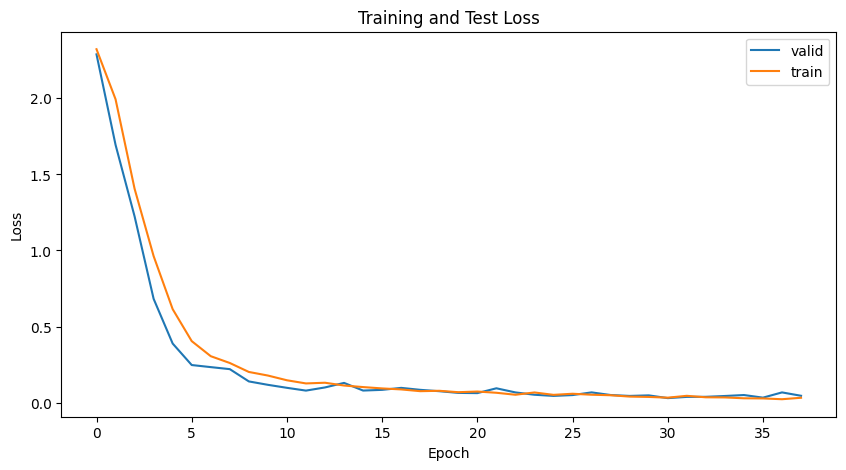

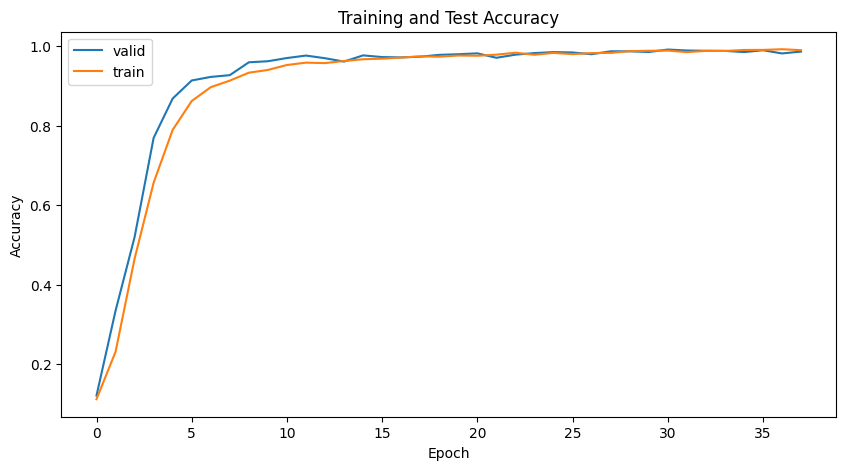

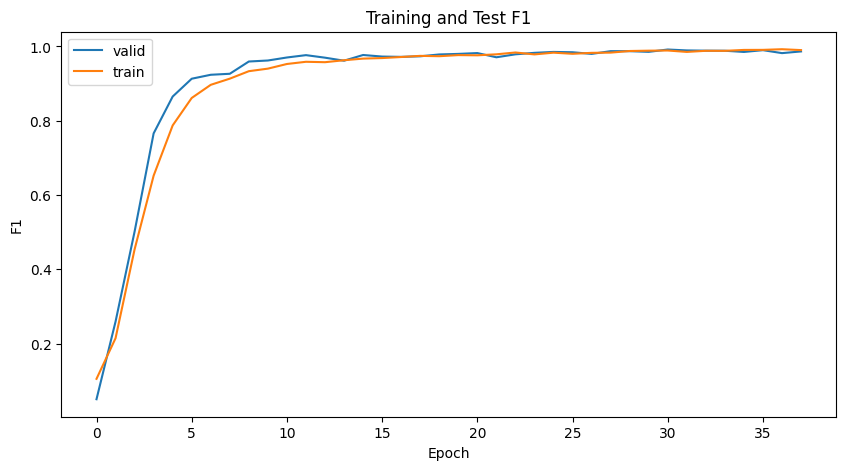

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [04:47<00:00,  4.33it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)